In [2]:
#####################################################
#
# APLICAR PCA A DATOS QUE NUNCA HA VISTO
#
#####################################################
# Deben cargarse los archivos
# - preprocessor_cat.joblib
# - pca_pipe_num.joblib
# - pca_metadata.json
# - T_train_final_objetivo.csv
# - csv de tus nuevos datos
# Devolverá T_new_final.csv: el csv de PCA aplicado a los nuevos datos

# === Cargar artefactos para inferencia ===
import joblib
import json
import pandas as pd

#####################################################
#preprocessor_cat = joblib.load("../preprocessing/preprocessor_cat.joblib")
pca_pipe = joblib.load("../preprocessing/pca_pipe_num.joblib")
with open("../preprocessing/pca_metadata.json", "r") as f:
    #####################################################
    meta = json.load(f)

cols_num = meta["cols_num"]
# cols_cat = meta["cols_cat"]
pc_cols = meta["pc_cols"]
# cat_out_cols = meta["cat_out_cols"]

# PCA DE ENTRENAMIENTO CON OBJETIVO
#####################################################
entrenamiento = pd.read_csv("../preprocessing/T_train_final_objetivo.csv")  ### todas las pca, categoricas y objetivo

#####################################################
entrenamiento_pca_objetivo = entrenamiento[pc_cols]

entrenamiento.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,objetivo
0,2.548766,-0.533196,-1.345833,-1.403101,0.696319,-0.055441,-0.023956,-0.021625,0.594017
1,-3.192166,-0.749290,-0.720432,-0.505921,-0.227657,-0.032160,-0.051353,0.008505,0.072014
2,-3.599883,-1.030802,-0.038419,-0.212926,-0.192728,-0.034790,-0.052418,0.005928,0.095197
3,0.920054,-0.449899,-0.487193,-0.333376,-0.408303,0.208304,-0.007324,-0.020099,0.547354
4,1.990848,0.732242,1.051311,0.392595,-0.662599,-0.135006,0.024582,-0.220002,1.245754
5,-2.185725,1.647859,0.739267,-0.919599,0.169827,0.016181,0.037863,0.007011,-0.000044
6,1.746619,0.335521,1.034523,-1.407812,0.509396,-0.561701,0.089914,0.629344,1.013433
7,0.775974,0.987111,0.429320,-0.691120,-0.735772,-0.105016,0.035582,-0.052203,0.928848
8,0.248888,-0.938279,0.780306,-0.364646,-0.303392,0.356418,0.136090,-0.007025,0.485875
9,1.148567,0.438849,0.464530,1.928595,-0.285420,-0.033015,-0.017754,0.060986,1.809125


In [9]:
# NUEVOS DATOS
#####################################################
new_df = pd.read_csv("../../data/stellar_desconocido.csv")
#####################################################

X_new_num = new_df[cols_num]

# Categóricas (mismo encoder, sin re-ajustar)
# X_new_cat_proc = preprocessor_cat.transform(X_new_cat)
# df_new_cat_encode = pd.DataFrame(X_new_cat_proc, columns=cat_out_cols, index=new_df.index)

# Numéricas → (preproc_num + StdScaler + PCA) con el pipeline guardado
T_new = pca_pipe.transform(X_new_num)
T_new_df = pd.DataFrame(T_new, columns=pc_cols, index=new_df.index)

# Final
T_new_final = T_new_df
T_new_final.to_csv("T_new_final.csv", index=False)

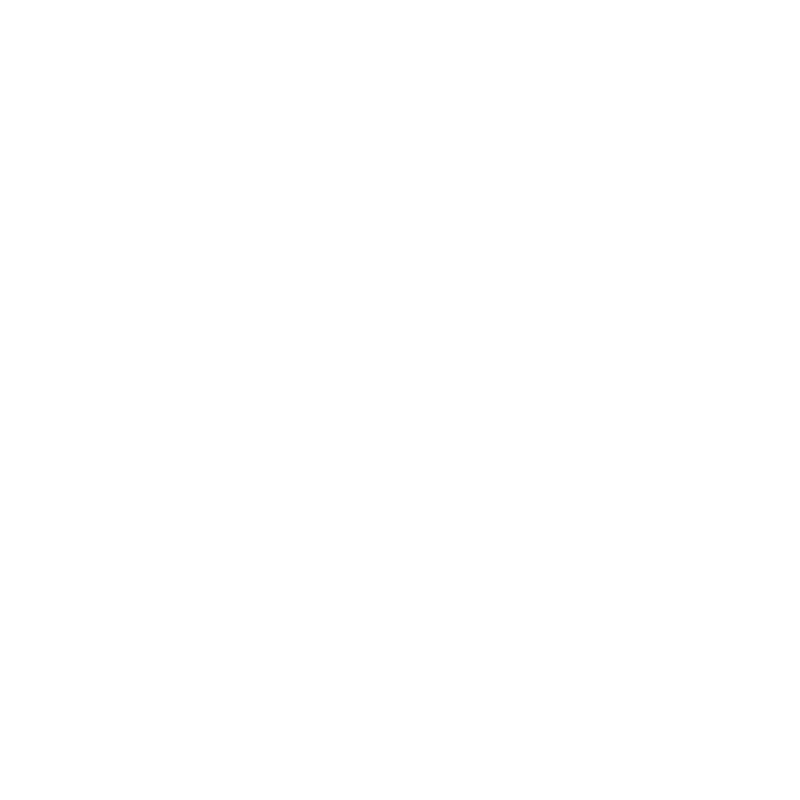

In [11]:
import datashader as ds
import datashader.transfer_functions as tf
from IPython.display import display

df_plot = T_new_final.iloc[:, :3].copy()

# Canvas
cvs = ds.Canvas(plot_width=800, plot_height=800)

# Aggregate
agg = cvs.points(df_plot, 'PC1', 'PC2', agg=ds.count())

# Shade (convertir agregación en imagen)
img = tf.shade(
    agg,
    cmap=["black", "purple", "cyan", "white"],
    how="eq_hist"
)


display(img.to_pil())

In [12]:
T_new_final

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.221847,-0.566804,-0.430395,0.315429,-0.453420,-0.162026,-0.066783,0.077021
1,0.801747,2.132453,-1.270229,0.482498,0.447833,0.049086,-0.063741,0.030473
2,-1.084713,-1.019521,1.397841,0.234855,-0.704936,-0.063158,-0.114445,0.067809
3,-0.633757,0.301909,0.428050,0.845014,-0.034192,0.006027,-0.049463,0.080476
4,1.561138,2.238372,-1.354920,-0.292037,0.570593,0.055629,-0.056016,-0.010009
5,0.401883,-0.602860,0.728020,-1.430921,-0.533314,-0.139213,-0.051511,0.072616
6,-0.114834,1.706100,-0.734249,1.655927,0.539049,0.158751,-0.030513,0.039511
7,-1.331331,0.778196,-0.528730,-0.660990,-0.173092,0.038904,-0.079453,0.031212
8,0.263872,-0.035995,-1.824665,0.013719,-0.564163,-0.103819,-0.105033,0.067420
9,1.882533,1.398545,1.390293,0.632826,0.501744,0.072352,-0.077504,0.027601
